In [2]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torch torchvision


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline
from IPython.display import Image

In [5]:
from __future__ import print_function
import cv2
import torch
import torch.nn.functional as F
from torchvision import transforms
import time

# Load pretrained model
model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
# Segment people only for the purpose of human silhouette extraction
people_class = 15

# Evaluate model
model.eval()
print ("Model has been loaded.")

blur = torch.FloatTensor([[[[1.0, 2.0, 1.0],[2.0, 4.0, 2.0],[1.0, 2.0, 1.0]]]]) / 16.0

# Use GPU if supported, for better performance
if torch.cuda.is_available():
	model.to('cuda')
	blur = blur.to('cuda')
	
# Apply preprocessing (normalization)
preprocess = transforms.Compose([
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to create segmentation mask
def makeSegMask(img):
    # Scale input frame
	frame_data = torch.FloatTensor( img ) / 255.0

	input_tensor = preprocess(frame_data.permute(2, 0, 1))
    
    # Create mini-batch to be used by the model
	input_batch = input_tensor.unsqueeze(0)

    # Use GPU if supported, for better performance
	if torch.cuda.is_available():
		input_batch = input_batch.to('cuda')

	with torch.no_grad():
		output = model(input_batch)['out'][0]

	segmentation = output.argmax(0)

	bgOut = output[0:1][:][:]
	a = (1.0 - F.relu(torch.tanh(bgOut * 0.30 - 1.0))).pow(0.5) * 2.0

	people = segmentation.eq( torch.ones_like(segmentation).long().fill_(people_class) ).float()

	people.unsqueeze_(0).unsqueeze_(0)
	
	for i in range(3):
		people = F.conv2d(people, blur, stride=1, padding=1)

	# Activation function to combine masks - F.hardtanh(a * b)
	combined_mask = F.relu(F.hardtanh(a * (people.squeeze().pow(1.5)) ))
	combined_mask = combined_mask.expand(1, 3, -1, -1)

	res = (combined_mask * 255.0).cpu().squeeze().byte().permute(1, 2, 0).numpy()

	return res

if __name__ == '__main__':
    # Loads video file into CV2
    video = cv2.VideoCapture('./Dataset/001-nm-01-090(trimmed).mp4')
    
    # Get video file's dimensions
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
    
    # Creates output video file
    out = cv2.VideoWriter('silhouette_output.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

    prev_frame_time = 0
    new_frame_time = 0

    while (video.isOpened):
        # Read each frame one by one
        success, img = video.read()
        
        # Run if there are still frames left
        if (success):
            
            # Apply background subtraction to extract foreground (silhouette)
            mask = makeSegMask(img)
            
            # Apply thresholding to convert mask to binary map
            ret,thresh = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
            
            # Write processed frame to output file
            out.write(thresh)
            
            new_frame_time = time.time()
            fps = 1/(new_frame_time-prev_frame_time)
            prev_frame_time = new_frame_time 
            fps = str(fps)
            print(fps)
            # cv2.rectangle(mask, (10, 2), (100,20), (255,255,255), -1)
            # cv2.putText(mask, fps, (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
            
            # Show extracted silhouette only, by multiplying mask and input frame
            final = cv2.bitwise_and(thresh, img)
            
            # Show current frame
            cv2.imshow('Frame', final)
            cv2.imshow('Segmentation Mask', mask)
                        
            # Allow early termination with Esc key
            key = cv2.waitKey(10)
            if key == 27:
                break
        # Break when there are no more frames  
        else:
            break

    # Release resources
    cv2.destroyAllWindows()
    video.release()
    out.release()

Using cache found in C:\Users\nitin/.cache\torch\hub\pytorch_vision_v0.6.0
C:\Users\nitin\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nitin\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has been loaded.
5.838784674330686e-10
1.1013612142559484
1.2447379948172321
1.1834235649560467
1.2115875296989305
1.223768209308134
1.1180588876306974
1.1968191002364645
1.2248041959205938
1.174160706707292
1.1387084767362212
1.0095053661887388
1.1471503421099198
1.0697045365804019
1.0169927806990022
1.250707534862362
1.1698274448290904
1.1621632180665877
1.1494897008364302
0.9848720158357069
1.072189910590853
1.1135751002052026
1.154130146396604
1.1725785240783317
1.1991640196815612
1.1926264969661884
1.1253372211980566
1.1850663083282875
1.1854906908699525
1.1893481375744104
1.1702181263526352
1.1944054390773502
1.187445359956152
1.1679755082650416
1.1811693461177997
1.091455181108837
0.9701854969399968
1.1352749621264102
1.027329540931608
0.9367962950761455
1.0511745033723363
1.1932636981381144
1.1941667162539251
1.1545768331157304
1.2682529464182313
1.7852386700467686
1.678268044075151
1.784436620077839
1.7328870185017935
1.702936642274835
1.736860303858126
1.654574108225919

In [1]:
import cv2
import numpy as np
import csv

# Function to calculate center of mass
def calculate_center_of_mass(mask):
    M = cv2.moments(mask)
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        return cX, cY
    else:
        return None, None

# Load the video
video_path = './silhouette_output.avi'
cap = cv2.VideoCapture(video_path)

# CSV file to write data
csv_file = open('bounding_box_center_of_mass.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Frame', 'Bounding Box (x, y, w, h)', 'Center of Mass (x, y)'])

frame_number = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Threshold the grayscale image to get the silhouette
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw bounding box around the largest contour
    if contours:
        # Get the largest contour
        max_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(max_contour)

        # Draw bounding box
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Calculate center of mass
        mask = np.zeros_like(gray)
        cv2.drawContours(mask, [max_contour], -1, (255), thickness=cv2.FILLED)
        cX, cY = calculate_center_of_mass(mask)
        if cX is not None and cY is not None:
            # Draw center of mass
            cv2.circle(frame, (cX, cY), 5, (0, 0, 255), -1)

            # Print x, y coordinates and center of mass
            print("Bounding Box (x, y, w, h):", (x, y, w, h))
            print("Center of Mass (x, y):", (cX, cY))

            # Write data to CSV
            csv_writer.writerow([frame_number, (x, y, w, h), (cX, cY)])
        # Increment frame number
        frame_number += 1
    # Display the frame
    cv2.imshow('CenterOfMass',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# Close CSV file
csv_file.close()
cap.release()
cv2.destroyAllWindows()


Bounding Box (x, y, w, h): (296, 120, 24, 64)
Center of Mass (x, y): (309, 155)
Bounding Box (x, y, w, h): (296, 96, 24, 88)
Center of Mass (x, y): (308, 142)
Bounding Box (x, y, w, h): (296, 57, 24, 127)
Center of Mass (x, y): (310, 127)
Bounding Box (x, y, w, h): (296, 56, 24, 128)
Center of Mass (x, y): (309, 122)
Bounding Box (x, y, w, h): (288, 56, 32, 128)
Center of Mass (x, y): (306, 125)
Bounding Box (x, y, w, h): (288, 48, 32, 144)
Center of Mass (x, y): (304, 124)
Bounding Box (x, y, w, h): (288, 48, 32, 144)
Center of Mass (x, y): (300, 117)
Bounding Box (x, y, w, h): (280, 48, 32, 144)
Center of Mass (x, y): (295, 122)
Bounding Box (x, y, w, h): (264, 48, 48, 144)
Center of Mass (x, y): (291, 120)
Bounding Box (x, y, w, h): (256, 49, 56, 143)
Center of Mass (x, y): (286, 124)
Bounding Box (x, y, w, h): (248, 48, 64, 144)
Center of Mass (x, y): (283, 122)
Bounding Box (x, y, w, h): (240, 48, 64, 144)
Center of Mass (x, y): (277, 125)
Bounding Box (x, y, w, h): (237, 52, 67, 

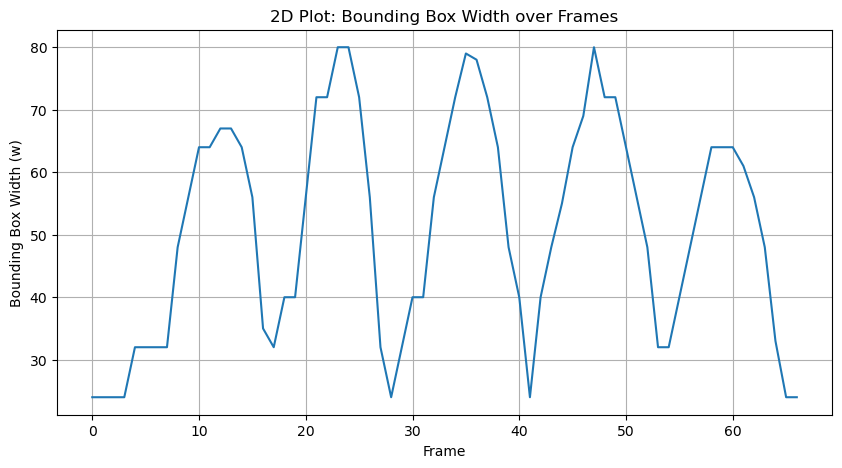

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Read the CSV file
df = pd.read_csv("./bounding_box_center_of_mass.csv")

# Extract relevant data
frames = df['Frame']
w_values = df['Bounding Box (x, y, w, h)'].apply(lambda x: eval(x)[2])
h_values = df['Bounding Box (x, y, w, h)'].apply(lambda x: eval(x)[3])

# Create 2D plot
plt.figure(figsize=(10, 5))
plt.plot(frames, w_values)
plt.xlabel('Frame')
plt.ylabel('Bounding Box Width (w)')
plt.title('2D Plot: Bounding Box Width over Frames')
plt.grid(True)
plt.show()
